### 1. Loaded Embeddings and Labels

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random

import pickle
import json

In [4]:
# Function to load the data from the json file
def load_from_json(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

# Load these embeddings from the pickle files
train_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_GLoVe_train_embeddings.pkl"
val_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_GLoVe_val_embeddings.pkl"
test_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_GLoVe_test_embeddings.pkl"

train_embeddings_loaded = pickle.load(open(train_embeddings_file, "rb"))
val_embeddings_loaded = pickle.load(open(val_embeddings_file, "rb"))
test_embeddings_loaded = pickle.load(open(test_embeddings_file, "rb"))

# Load the labels from the json files
train_labels = {}
val_labels = {}
test_labels = {}

train_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_train_labels.json"
val_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_val_labels.json"
test_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_test_labels.json"

train_labels = load_from_json(train_label_path)
val_labels = load_from_json(val_label_path)
test_labels = load_from_json(test_label_path)

2. Remove samples above length of 174

In [5]:
# discarding the sentences with length greater than 174
# for train

train_labels = {k: v for k, v in train_labels.items() if len(v) <= 174}
train_embeddings_loaded = {k: v for k, v in train_embeddings_loaded.items() if len(v) <= 174}

# for val
val_labels = {k: v for k, v in val_labels.items() if len(v) <= 174}
val_embeddings_loaded = {k: v for k, v in val_embeddings_loaded.items() if len(v) <= 174}

# for test
test_labels = {k: v for k, v in test_labels.items() if len(v) <= 174}
test_embeddings_loaded = {k: v for k, v in test_embeddings_loaded.items() if len(v) <= 174}

3. Padding of the sentences to get same sequence lengths

In [6]:
"""
For each key, pad the embeddings and labels to the maximum length of 174 (for Task 1) and 83 (for Task 2)
For padding labels, use 'O' tag
For padding embeddings, use a vector of zeros
"""

max_length = 180

# Train Embeddings and Labels   
for key in train_embeddings_loaded:
    label = train_labels[key]
    embeddings = train_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    train_labels[key] = label
    train_embeddings_loaded[key] = embeddings

# Val Embeddings and Labels
for key in val_embeddings_loaded:
    label = val_labels[key]
    embeddings = val_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    val_labels[key] = label
    val_embeddings_loaded[key] = embeddings

# Test Embeddings and Labels
for key in test_embeddings_loaded:
    label = test_labels[key]
    embeddings = test_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    test_labels[key] = label
    test_embeddings_loaded[key] = embeddings

4. Label Indexing

In [7]:
# Get the unique labels
unique_labels = set()
for labels in train_labels.values():
    unique_labels.update(labels)

# Give each label a unique index
labels_to_index = {label: index for index, label in enumerate(unique_labels)}
print(labels_to_index)

{'I_PRECEDENT': 0, 'O': 1, 'B_COURT': 2, 'I_JUDGE': 3, 'B_OTHER_PERSON': 4, 'I_PROVISION': 5, 'B_CASE_NUMBER': 6, 'I_COURT': 7, 'B_ORG': 8, 'I_STATUTE': 9, 'I_CASE_NUMBER': 10, 'B_GPE': 11, 'I_GPE': 12, 'I_OTHER_PERSON': 13, 'I_RESPONDENT': 14, 'B_PROVISION': 15, 'B_PRECEDENT': 16, 'B_DATE': 17, 'B_WITNESS': 18, 'B_STATUTE': 19, 'I_ORG': 20, 'B_JUDGE': 21, 'B_RESPONDENT': 22, 'I_DATE': 23, 'B_PETITIONER': 24, 'I_PETITIONER': 25, 'I_WITNESS': 26}


In [8]:
# Function to convert labels to indices
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]

# Convert the labels to indices
train_labels_indices = labels_to_indices(train_labels.values(), labels_to_index)
val_labels_indices = labels_to_indices(val_labels.values(), labels_to_index)
test_labels_indices = labels_to_indices(test_labels.values(), labels_to_index)

In [9]:
train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels_indices, dtype=torch.long)

val_embeddings_tensor = torch.tensor([val_embeddings_loaded[key] for key in val_labels], dtype=torch.float)
val_labels_tensor = torch.tensor(val_labels_indices, dtype=torch.long)

test_embeddings_tensor = torch.tensor([test_embeddings_loaded[key] for key in test_labels], dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels_indices, dtype=torch.long)
                                  
# Create the DataLoader
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_embeddings_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_720266/1617646961.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)


In [10]:
# Iterate through the DataLoader
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break

torch.Size([32, 180, 300]) torch.Size([32, 180])


### BiLSTM-CRF Code

1. Class Implementing CRF

In [11]:
def log_sum_exp(x):
    """calculate log(sum(exp(x))) = max(x) + log(sum(exp(x - max(x))))
    """
    max_score = x.max(-1)[0]
    return max_score + (x - max_score.unsqueeze(-1)).exp().sum(-1).log()


IMPOSSIBLE = -1e4


class CRF(nn.Module):
    """General CRF module.
    The CRF module contain a inner Linear Layer which transform the input from features space to tag space.

    :param in_features: number of features for the input
    :param num_tag: number of tags. DO NOT include START, STOP tags, they are included internal.
    """

    def __init__(self, in_features, num_tags):
        super(CRF, self).__init__()

        self.num_tags = num_tags + 2
        self.start_idx = self.num_tags - 2
        self.stop_idx = self.num_tags - 1

        self.fc = nn.Linear(in_features, self.num_tags)

        # transition factor, Tij mean transition from j to i
        self.transitions = nn.Parameter(torch.randn(self.num_tags, self.num_tags), requires_grad=True)
        self.transitions.data[self.start_idx, :] = IMPOSSIBLE
        self.transitions.data[:, self.stop_idx] = IMPOSSIBLE

    def forward(self, features):
        """decode tags

        :param features: [B, L, C], batch of unary scores
        :param masks: [B, L] masks
        :return: (best_score, best_paths)
            best_score: [B]
            best_paths: [B, L]
        """
        features = self.fc(features)
        return self.__viterbi_decode(features)

    def loss(self, features, tags):
        """negative log likelihood loss
        B: batch size, L: sequence length, D: dimension

        :param features: [B, L, D]
        :param ys: tags, [B, L]
        :param masks: masks for padding, [B, L]
        :return: loss
        """
        features = self.fc(features)
        forward_score = self.__forward_algorithm(features)
        gold_score = self.__score_sentence(features, tags)
        return (forward_score - gold_score).mean()

    def __score_sentence(self, features, tags):
        """Gives the score of a provided tag sequence

        :param features: [B, L, C]
        :param tags: [B, L]
        :param masks: [B, L]
        :return: [B] score in the log space
        """
        B, L, C = features.shape

        # emission score
        emit_scores = features.gather(dim=2, index=tags.unsqueeze(-1)).squeeze(-1)

        # transition score
        start_tag = torch.full((B, 1), self.start_idx, dtype=torch.long, device=tags.device)
        tags = torch.cat([start_tag, tags], dim=1)  # [B, L+1]
        trans_scores = self.transitions[tags[:, 1:], tags[:, :-1]]

        # last transition score to STOP tag
        last_tag = tags[:, -1]
        last_scores = self.transitions[self.stop_idx, last_tag]

        score = (trans_scores + emit_scores).sum(dim=1) + last_scores
        return score

    def __viterbi_decode(self, features):
        """decode to tags using viterbi algorithm

        :param features: [B, L, C], batch of unary scores
        :param masks: [B, L] masks
        :return: (best_score, best_paths)
            best_score: [B]
            best_paths: [B, L]
        """
        B, L, C = features.shape

        bps = torch.zeros(B, L, C, dtype=torch.long, device=features.device)  # back pointers

        # Initialize the viterbi variables in log space
        max_score = torch.full((B, C), IMPOSSIBLE, device=features.device)  # [B, C]
        max_score[:, self.start_idx] = 0

        for t in range(L):
            emit_score_t = features[:, t]  # [B, C]

            # [B, 1, C] + [C, C]
            acc_score_t = max_score.unsqueeze(1) + self.transitions  # [B, C, C]
            acc_score_t, bps[:, t, :] = acc_score_t.max(dim=-1)
            acc_score_t += emit_score_t
            max_score = acc_score_t

        # Transition to STOP_TAG
        max_score += self.transitions[self.stop_idx]
        best_score, best_tag = max_score.max(dim=-1)

        # Follow the back pointers to decode the best path.
        best_paths = []
        bps = bps.cpu().numpy()
        for b in range(B):
            best_tag_b = best_tag[b].item()
            best_path = [best_tag_b]
            for bps_t in reversed(bps[b]):
                best_tag_b = bps_t[best_tag_b]
                best_path.append(best_tag_b)
            # drop the last tag and reverse the left
            best_paths.append(best_path[-2::-1])

        return best_score, best_paths

    def __forward_algorithm(self, features):
        """calculate the partition function with forward algorithm.
        TRICK: log_sum_exp([x1, x2, x3, x4, ...]) = log_sum_exp([log_sum_exp([x1, x2]), log_sum_exp([x3, x4]), ...])

        :param features: features. [B, L, C]
        :param masks: [B, L] masks
        :return:    [B], score in the log space
        """
        B, L, C = features.shape

        scores = torch.full((B, C), IMPOSSIBLE, device=features.device)  # [B, C]
        scores[:, self.start_idx] = 0.
        trans = self.transitions.unsqueeze(0)  # [1, C, C]

        # Iterate through the sentence
        for t in range(L):
            emit_score_t = features[:, t].unsqueeze(2)  # [B, C, 1]
            score_t = scores.unsqueeze(1) + trans + emit_score_t  # [B, 1, C] + [1, C, C] + [B, C, 1] => [B, C, C]
            score_t = log_sum_exp(score_t)  # [B, C]

            scores = score_t
            
        scores = log_sum_exp(scores + self.transitions[self.stop_idx])
        return scores

In [12]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, tagset_size, embedding_dim, hidden_dim, num_lstm_layers=2):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=num_lstm_layers,
                       bidirectional=True, batch_first=True)
        self.crf = CRF(hidden_dim, self.tagset_size)


    def loss(self, embd, tags):
        # Get the emission scores from the BiLSTM
        lstm_out, _ = self.lstm(embd)

        # Calculate and return the CRF loss
        return self.crf.loss(lstm_out, tags)

    def forward(self, embd):
        # Directly pass the embeddings to the LSTM
        lstm_out, _ = self.lstm(embd)

        # Pass the output of LSTM to CRF
        scores, tag_seq = self.crf(lstm_out)
        return scores, tag_seq

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
BATCH_SIZE = 32
NUM_CLASSES = len(labels_to_index)

# Create the model
model = BiLSTM_CRF(NUM_CLASSES, EMBEDDING_DIM, HIDDEN_DIM, num_lstm_layers=2)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

EPOCHS = 10

train_losses = []
val_losses = []
train_f1 = []
val_f1 = []

# Training loop
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    train_preds = []
    val_preds = []
    train_true = []
    val_true = []
    for i, (embeddings, labels) in enumerate(train_loader):
        print(i)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss = model.loss(embeddings, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Prediction
        _, predicted = model(embeddings)
        # Assuming 'predicted' is a list of lists with variable lengths
        max_len = max(len(p) for p in predicted)  # Find the maximum sequence length

        # Pad the sequences
        padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
        predicted = torch.tensor(padded_predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Calculate running training loss
        running_train_loss += loss.item()

        # Append the predictions and true labels
        train_preds.extend(predicted.tolist())
        train_true.extend(labels.tolist())

    # Calculate the training loss
    running_train_loss /= len(train_loader)
    train_losses.append(running_train_loss)

    # Calculate the training f1 score
    train_f1.append(f1_score(train_true, train_preds, average='macro'))

    # Calculate the training accuracy
    train_accuracy = accuracy_score(train_true, train_preds)


    # Validation loop
    with torch.no_grad():
        for i, (embeddings, labels) in enumerate(val_loader):

            # Run forward pass
            loss = model.loss(embeddings, labels)

            # Prediction
            _, predicted = model(embeddings)
            # Assuming 'predicted' is a list of lists with variable lengths
            max_len = max(len(p) for p in predicted)

            # Pad the sequences
            padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
            predicted = torch.tensor(padded_predicted, dtype=torch.long)

            labels = labels.view(-1)
            predicted = predicted.view(-1)

            # Calculate running validation loss
            running_val_loss += loss.item()

            # Append the predictions and true labels
            val_preds.extend(predicted.tolist())
            val_true.extend(labels.tolist())

    # Calculate the validation loss
    running_val_loss /= len(val_loader)
    val_losses.append(running_val_loss)

    # Calculate the validation f1 score
    val_f1.append(f1_score(val_true, val_preds, average='macro'))

    # Calculate the validation accuracy
    val_accuracy = accuracy_score(val_true, val_preds)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {running_train_loss:.4f}, Train F1: {train_f1[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {running_val_loss:.4f}, Val F1: {val_f1[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
Epoch [1/10], Train Loss: 29.8065, Train F1: 0.1245, Train Accuracy: 0.9717, Val Loss: 9.7277, Val F1: 0.3

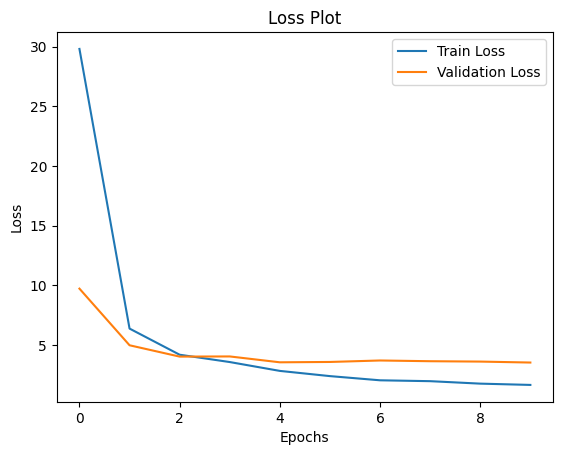

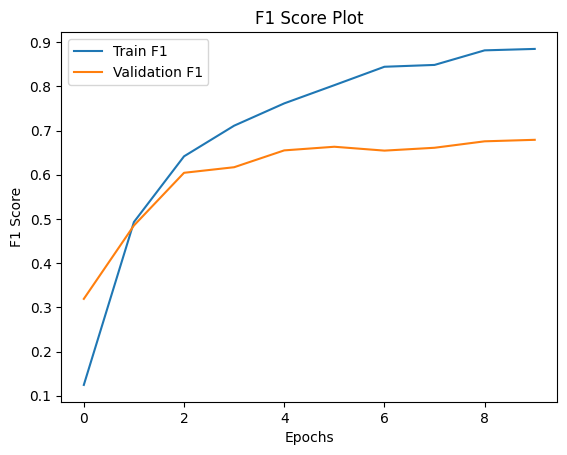

In [14]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Plot")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation f1 score
plt.plot(train_f1, label='Train F1')
plt.plot(val_f1, label='Validation F1')
plt.title("F1 Score Plot")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [15]:
# Test loop

test_preds = []
test_true = []

with torch.no_grad():
    for i, (embeddings, labels) in enumerate(test_loader):

        # Run forward pass
        loss = model.loss(embeddings, labels)

        # Prediction
        _, predicted = model(embeddings)
        # Assuming 'predicted' is a list of lists with variable lengths
        max_len = max(len(p) for p in predicted)

        # Pad the sequences
        padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
        predicted = torch.tensor(padded_predicted, dtype=torch.long)

        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds.extend(predicted.tolist())
        test_true.extend(labels.tolist())

# Calculate the test f1 score
test_f1 = f1_score(test_true, test_preds, average='macro')

# Calculate the test accuracy
test_accuracy = accuracy_score(test_true, test_preds)

print(f'Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test F1: 0.6638, Test Accuracy: 0.9905


In [16]:
# Save the model to a pt file
torch.save(model.state_dict(), 'Task1_BiLSTMCRF_GLOVE.pt')